# Capstone 2: *National Transit Database*
## *Preprocessing and Training*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing and Training](#3_Preprocessing_and_Training)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Importing the Dependencies](#3.3_Importing_the_Dependencies)
  * [3.4 Importing the Data](#3.4_Importing_the_Data)
  * [3.5 Defining Safety](#3.5_Defining_Safety)
      * [3.5.1 'Total Events' Column](#3.5.1_Total_Events_Column)
      * [3.5.2 Drop Columns Captured by 'Total Events'](#3.5.2_Drop_Columns_Captured_by_Total_Events)
      * [3.5.3 Change Dataframes to Annual](#3.5.3_Change_Dataframes_to_Annual)
      * [3.5.4 Dropping Unneeded Columns](#3.5.4_Dropping_Unneeded_Columns)
      * [3.5.5 Add 'Cumulative Safety per 100K VRM' Column](#3.5.5_Add_Cumulative_Safety_per_100K_VRM_Column)
      * [3.5.6 Drop Columns Accounted for in 'Cumulative Safety per 100K VRM'](#3.5.6_Add_Cumulative_Safety_per_100K_VRM_Column)
  * [3.6 Encoding the Categorical Features](#3.6_Encoding_the_Categorical_Features)
  * [3.7 Exploring the Data](#3.7_Exploring_the_Data)
  * [3.8 Model Selection](#3.8_Model_Selection)
      * [3.8.1 Train/Test Split](#3.8.1_Train_Test_Split)
      * [3.8.2 Linear Regression](#3.8.2_Linear_Regression)
      * [3.8.3 Random Forest](#3.8.3_Random_Forest)
      * [3.8.4 KNN](#3.8.4_KNN)
      * [3.8.5 Comparing the Models' Performance](#3.8.5_Comparing_the_Models_Performance)
  * [3.9 Save the Data](#3.9_Save_the_Data)
  * [3.10 Summary](#3.10_Summary)

## 3.2 Introduction
<a id='3.2_Introduction'></a>

In the preceeding notebook, I refined the dataframes and began to explore the relationships between the variables.  In this notebook, I will further refine the data so only clear, valuable, numeric columns are remaining for the independent variables and so there is a single, clear, and distinct value for the dependent variable.  I will then split the data in train/test sets and evaluate the performance of several models to determine which is best suited for this project.

## 3.3 Importing the Dependencies
<a id='3.3_Importing_the_Dependencies'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_rows', 70)

## 3.4 Importing the Data
<a id='3.4_Importing_the_Data'></a>

In [2]:
National_data = pd.read_csv("reduced_data.csv")
Nashville_data = pd.read_csv("Nashville_data.csv")

In [3]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   5 DIgit NTD ID                         129752 non-null  int64  
 1   Agency                                 129752 non-null  object 
 2   Organization Type                      129752 non-null  object 
 3   Mode                                   129752 non-null  object 
 4   Type of Service                        129752 non-null  object 
 5   Rail (Y/N)                             129752 non-null  bool   
 6   Primary UZA Code                       129752 non-null  float64
 7   Primary UZA Name                       129752 non-null  object 
 8   Primary UZA Sq Miles                   129752 non-null  float64
 9   Primary UZA Population                 129752 non-null  float64
 10  Service Area Sq Miles                  129752 non-null  

In [4]:
Nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5 DIgit NTD ID                         750 non-null    int64  
 1   Agency                                 750 non-null    object 
 2   Organization Type                      750 non-null    object 
 3   Mode                                   750 non-null    object 
 4   Type of Service                        750 non-null    object 
 5   Rail (Y/N)                             750 non-null    bool   
 6   Primary UZA Code                       750 non-null    float64
 7   Primary UZA Name                       750 non-null    object 
 8   Primary UZA Sq Miles                   750 non-null    float64
 9   Primary UZA Population                 750 non-null    float64
 10  Service Area Sq Miles                  750 non-null    float64
 11  Servic

## 3.5 Defining Safety
<a id='3.5_Defining_Safety'></a>

The FTA requires covered public transportation providers to establish Safety Performance Measures (SPMs) and use them to set annual Safety Perform Targets (SPTs) based.  These targets must depend only on data submittable to the NTD. Since my goal is to assit Nashville in its decision-making, I will use the SPMs of it's largest NTD reporter to guide my definition of safety.  The SPMs and SPTs for the Metropolitan Transit Authority (MTA) dba WeGo Public Transit can be found on page 8 of this document: [MTA Safety Performance Measures](https://www.wegotransit.com/file.aspx?DocumentId=102).  MTA's chosen SPMs match the example given by the FTA in their Safety Performance Targets Guide which can be found here: [FTA SPT Guide](https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-06/SPTs-Guide-v2-20210629.pdf).

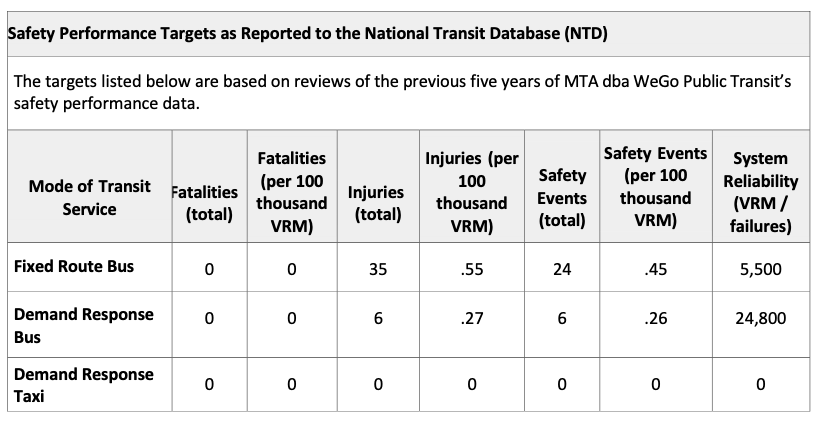

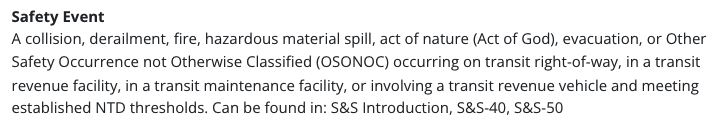

### 3.5.1 'Total Events' Column
<a id='3.5.1_Total_Events_Column'></a>
The NTD database does not have a column called 'Total Safety Events' so I will verify that the 'Toal Events' column is a total of all the events listed in the definition above from given in the [FTA Glossary](https://www.transit.dot.gov/ntd/national-transit-database-ntd-glossary).

In [5]:
#Check to see if 'Total Events" captures all data in columns 'Total Collisions', 'Total Derailments', 'Total Fires',
#'Total Security Events', and 'Total Events Not Otherwise Classified'

National_events = National_data.iloc[:, 18:24]
Nashville_events = Nashville_data.iloc[:, 18:24]
count5 = 0
count6 = 0

for i in National_events.index:
    if sum(National_events.iloc[i,[5]]) != sum(National_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)

for i in Nashville_events.index:
    if sum(Nashville_events.iloc[i,[5]]) != sum(Nashville_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)        

print('There are ',count5, "rows where 'Total Events' does not match the sum of the other National columns")
print('There are ',count6, "rows where 'Total Events' does not match the sum of the other Nashville columns")

There are  0 rows where 'Total Events' does not match the sum of the other National columns
There are  0 rows where 'Total Events' does not match the sum of the other Nashville columns


Since the 'Total Events' column is confirmed to be the total of the other columns, I can drop the other columns from both the National and Nashville dataframes.

### 3.5.2 Drop Columns Captured by 'Total Events'
<a id='3.5.2_Drop_Columns_Captured_by_Total_Events'></a>

In [6]:
National_data.shape

(129752, 26)

In [7]:
Nashville_data.shape

(750, 26)

In [8]:
National_data = National_data.drop(National_data.iloc[:, 18:23], axis=1)
Nashville_data = Nashville_data.drop(Nashville_data.iloc[:, 18:23], axis=1)


In [9]:
National_data.shape

(129752, 21)

In [10]:
Nashville_data.shape

(750, 21)

### 3.5.3 Change Dataframes to Annual
<a id='3.5.3_Change_Dataframes_to_Annual'></a>
Since goals reported to the FTA are in annual form, I will change the rows of the dataframes to match.  

In [11]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   5 DIgit NTD ID           129752 non-null  int64  
 1   Agency                   129752 non-null  object 
 2   Organization Type        129752 non-null  object 
 3   Mode                     129752 non-null  object 
 4   Type of Service          129752 non-null  object 
 5   Rail (Y/N)               129752 non-null  bool   
 6   Primary UZA Code         129752 non-null  float64
 7   Primary UZA Name         129752 non-null  object 
 8   Primary UZA Sq Miles     129752 non-null  float64
 9   Primary UZA Population   129752 non-null  float64
 10  Service Area Sq Miles    129752 non-null  float64
 11  Service Area Population  129752 non-null  float64
 12  Year                     129752 non-null  int64  
 13  Month                    129752 non-null  int64  
 14  Vehi

In [12]:
# Creating the annual columns

National_annual = National_data.copy()
National_annual[[ 'Vehicle Revenue Miles Sum', 'Ridership Sum',
                 'Total Events Annual by Mode',
                 'Total Fatalities Annual by Mode',
                 'Total Injuries Annual by Mode']] = (National_annual.groupby(['5 DIgit NTD ID',
                                                                               'Agency','Primary UZA Name',
                                                                               'Mode','Year'])
                                                      [['Vehicle Revenue Miles', 'Ridership', 'Total Events',
                                                        'Total Fatalities', 'Total Injuries']].transform('sum'))

Nashville_annual = Nashville_data.copy()
Nashville_annual[[ 'Vehicle Revenue Miles Sum', 'Ridership Sum',
                  'Total Events Annual by Mode',
                  'Total Fatalities Annual by Mode',
                  'Total Injuries Annual by Mode']] = (Nashville_annual.groupby(['5 DIgit NTD ID',
                                                                                 'Agency','Primary UZA Name',
                                                                                 'Mode','Year'])
                                                       [['Vehicle Revenue Miles', 'Ridership', 'Total Events',
                                                         'Total Fatalities', 'Total Injuries']].transform('sum'))

National_annual[['Primary UZA Sq Miles Mean', 
                  'Primary UZA Population Mean', 
                  'Service Area Sq Miles Mean',
                  'Service Area Population Mean']] = (National_annual.groupby(['5 DIgit NTD ID', 'Agency',
                                                                          'Primary UZA Name', 'Mode','Year'])
                                                                         [['Primary UZA Sq Miles', 
                                                                           'Primary UZA Population', 
                                                                           'Service Area Sq Miles',
                                                                           'Service Area Population']].transform('mean'))
 
Nashville_annual[['Primary UZA Sq Miles Mean', 
                  'Primary UZA Population Mean', 
                  'Service Area Sq Miles Mean',
                  'Service Area Population Mean']] = (Nashville_annual.groupby(['5 DIgit NTD ID', 'Agency',
                                                                          'Primary UZA Name', 'Mode','Year'])
                                                                         [['Primary UZA Sq Miles', 
                                                                           'Primary UZA Population', 
                                                                           'Service Area Sq Miles',
                                                                           'Service Area Population']].transform('mean'))
 

In [13]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   5 DIgit NTD ID                   129752 non-null  int64  
 1   Agency                           129752 non-null  object 
 2   Organization Type                129752 non-null  object 
 3   Mode                             129752 non-null  object 
 4   Type of Service                  129752 non-null  object 
 5   Rail (Y/N)                       129752 non-null  bool   
 6   Primary UZA Code                 129752 non-null  float64
 7   Primary UZA Name                 129752 non-null  object 
 8   Primary UZA Sq Miles             129752 non-null  float64
 9   Primary UZA Population           129752 non-null  float64
 10  Service Area Sq Miles            129752 non-null  float64
 11  Service Area Population          129752 non-null  float64
 12  Ye

### 3.5.4 Dropping Unneeded Columns
<a id='3.5.4_Dropping_Unneeded_Columns'></a>

'Primary UZA Code' and 'Primary UZA Population' are both ordinal representations of the ranking of population size.  However, 'Primary UZA Code' has the one value (602) which is out of place.  So, 'Primary UZA Code' will be removed.

The columns 'Vehicles' and 'Vehicle Revenue Hours' will be dropped because they are too closely related to 'Vehicle Revenue Miles' which is used to produce the target.

I will also remove the identifier columns, '5 DIgit NTD ID', 'Agency', and 'Primary UZA Name' and the remaining time-based column, 'Year', after I use them in the groupby to reduce the dataframe to annual values, so that all references to location and time will be omitted.

In [14]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   5 DIgit NTD ID                   129752 non-null  int64  
 1   Agency                           129752 non-null  object 
 2   Organization Type                129752 non-null  object 
 3   Mode                             129752 non-null  object 
 4   Type of Service                  129752 non-null  object 
 5   Rail (Y/N)                       129752 non-null  bool   
 6   Primary UZA Code                 129752 non-null  float64
 7   Primary UZA Name                 129752 non-null  object 
 8   Primary UZA Sq Miles             129752 non-null  float64
 9   Primary UZA Population           129752 non-null  float64
 10  Service Area Sq Miles            129752 non-null  float64
 11  Service Area Population          129752 non-null  float64
 12  Ye

In [15]:
# Dropping columns

National_annual = National_annual.drop(National_annual.iloc[:, np.r_[6, 8:12, 13:21]], axis=1)
Nashville_annual = Nashville_annual.drop(Nashville_annual.iloc[:, np.r_[6, 8:12, 13:21]], axis=1)


In [16]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 17 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   5 DIgit NTD ID                   129752 non-null  int64  
 1   Agency                           129752 non-null  object 
 2   Organization Type                129752 non-null  object 
 3   Mode                             129752 non-null  object 
 4   Type of Service                  129752 non-null  object 
 5   Rail (Y/N)                       129752 non-null  bool   
 6   Primary UZA Name                 129752 non-null  object 
 7   Year                             129752 non-null  int64  
 8   Vehicle Revenue Miles Sum        129752 non-null  int64  
 9   Ridership Sum                    129752 non-null  int64  
 10  Total Events Annual by Mode      129752 non-null  int64  
 11  Total Fatalities Annual by Mode  129752 non-null  int64  
 12  To

In [17]:
#Condensing the dataframes by dropping duplicate rows (so I have one per annual value instead of up to 12)

National_annual = National_annual.drop_duplicates()
Nashville_annual = Nashville_annual.drop_duplicates()

In [18]:
National_annual.shape

(11739, 17)

In [19]:
National_annual = National_annual.drop(['Year', '5 DIgit NTD ID','Agency','Primary UZA Name'], axis=1)
Nashville_annual = Nashville_annual.drop(['Year', '5 DIgit NTD ID','Agency','Primary UZA Name'], axis=1)


### 3.5.5 Add 'Cumulative Safety per 100K VRM' Column
<a id='3.5.5_Add_Cumulative_Safety_per_100K_VRM_Column'></a>
In order to have a single column for y, I will combine the three categories of SPTs (fatalities, injuries, and events) into one and present it as a value per 100,000 VRM.  

In [20]:
National_Cumulative_Safety = (National_annual['Total Fatalities Annual by Mode'] + National_annual['Total Injuries Annual by Mode'] + National_annual['Total Events Annual by Mode'])
Nashville_Cumulative_Safety = (Nashville_annual['Total Fatalities Annual by Mode'] + Nashville_annual['Total Injuries Annual by Mode'] + Nashville_annual['Total Events Annual by Mode'])

National_annual['Cumulative Safety per 100K VRM'] = (National_Cumulative_Safety/National_annual['Vehicle Revenue Miles Sum'])*100000
Nashville_annual['Cumulative Safety per 100K VRM'] = (Nashville_Cumulative_Safety/Nashville_annual['Vehicle Revenue Miles Sum'])*100000


In [21]:
National_annual['Cumulative Safety per 100K VRM'].isna().sum()

35

In [22]:
Nashville_annual['Cumulative Safety per 100K VRM'].isna().sum()


0

In rows where there were no fatalities, injuries, or events, I end up with Nans because I have divided by zero.  I will replace the Nans with zeros since that is the logical value.

In [23]:
National_annual['Cumulative Safety per 100K VRM'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
National_annual['Cumulative Safety per 100K VRM'].isna().sum()


0

In [24]:
National_annual['Cumulative Safety per 100K VRM'].isna().sum()

0

In [25]:
National_annual.shape

(11739, 14)

### 3.5.6 Drop Columns Accounted for in 'Cumulative Safety per 100K VRM'
<a id='3.5.6_Add_Cumulative_Safety_per_100K_VRM_Column'></a>
I can now drop the 'Total Revenue Miles', 'Total Fatalities', 'Total Injuries', and 'Total Events' columns since they are accounted for in my new 'Cumulative Safety per 100K VRM' column.

In [26]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11739 entries, 0 to 129751
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Organization Type                11739 non-null  object 
 1   Mode                             11739 non-null  object 
 2   Type of Service                  11739 non-null  object 
 3   Rail (Y/N)                       11739 non-null  bool   
 4   Vehicle Revenue Miles Sum        11739 non-null  int64  
 5   Ridership Sum                    11739 non-null  int64  
 6   Total Events Annual by Mode      11739 non-null  int64  
 7   Total Fatalities Annual by Mode  11739 non-null  int64  
 8   Total Injuries Annual by Mode    11739 non-null  int64  
 9   Primary UZA Sq Miles Mean        11739 non-null  float64
 10  Primary UZA Population Mean      11739 non-null  float64
 11  Service Area Sq Miles Mean       11739 non-null  float64
 12  Service Area Popu

In [27]:
National_annual = National_annual.drop(National_annual.iloc[:, np.r_[4, 6:9]], axis=1)
Nashville_annual = Nashville_annual.drop(Nashville_annual.iloc[:, np.r_[4, 6:9]], axis=1)

In [28]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11739 entries, 0 to 129751
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Organization Type               11739 non-null  object 
 1   Mode                            11739 non-null  object 
 2   Type of Service                 11739 non-null  object 
 3   Rail (Y/N)                      11739 non-null  bool   
 4   Ridership Sum                   11739 non-null  int64  
 5   Primary UZA Sq Miles Mean       11739 non-null  float64
 6   Primary UZA Population Mean     11739 non-null  float64
 7   Service Area Sq Miles Mean      11739 non-null  float64
 8   Service Area Population Mean    11739 non-null  float64
 9   Cumulative Safety per 100K VRM  11739 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 928.6+ KB


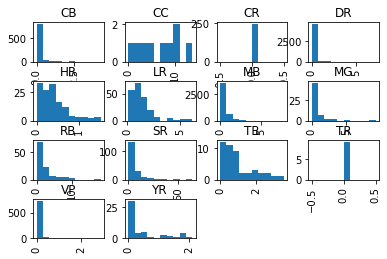

In [29]:
#National_annual.hist(x='Mode', y='Cumulative Safety per 100K VRM')
#plt.subplots(figsize=(20,20))
National_annual['Cumulative Safety per 100K VRM'].hist(by=National_annual['Mode']);

## 3.6 Encoding the Categorical Features
<a id= '3.6_Encoding_the_Categorical_Features'></a>
Time to encode the categorical variables

In [30]:
National_annual['Organization Type'].value_counts()

Independent Public Agency or Authority of Transit Service                6161
City, County or Local Government Unit or Department of Transportation    4199
MPO, COG or Other Planning Agency                                         262
State Government Unit or Department of Transportation                     214
Other Publicly-Owned or Privately Chartered Corporation                   175
Subsidiary Unit of a Transit Agency, Reporting Separately                 172
Private-Non-Profit Corporation                                            168
Private-For-Profit Corporation                                            138
University                                                                117
Private Provider Reporting on Behalf of a Public Entity                   106
Other                                                                      14
Consolidated Reporter                                                      13
Name: Organization Type, dtype: int64

In [31]:
#Renaming the Organization Types so the dummied column names won't be so cumbersome

National_annual['Organization Type'] = National_annual['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Subsidiary Unit of a Transit Agency, Reporting Separately' : 'F',
    'City, County or Local Government Unit or Department of Transportation': 'B',
    'University': 'I',
    'Consolidated Reporter': 'L',
    'Other': 'K',
    'Private-For-Profit Corporation': 'H',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',
    'MPO, COG or Other Planning Agency': 'C',
    'State Government Unit or Department of Transportation': 'D',
    'Private-Non-Profit Corporation': 'G',
    'Other Publicly-Owned or Privately Chartered Corporation': 'E'})


In [32]:
Nashville_annual['Organization Type'].unique()

array(['Private Provider Reporting on Behalf of a Public Entity',
       'Independent Public Agency or Authority of Transit Service'],
      dtype=object)

In [33]:
Nashville_annual['Organization Type'] = Nashville_annual['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',})


In [34]:
National_annual['Organization Type'].value_counts()

A    6161
B    4199
C     262
D     214
E     175
F     172
G     168
H     138
I     117
J     106
K      14
L      13
Name: Organization Type, dtype: int64

In [35]:
Nashville_annual['Organization Type'].value_counts()

A    58
J     9
Name: Organization Type, dtype: int64

In [36]:
National_annual = pd.get_dummies(National_annual, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])
Nashville_annual = pd.get_dummies(Nashville_annual, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])

In [37]:
National_annual.shape

(11739, 37)

In [38]:
Nashville_annual.shape

(67, 17)

In [39]:
# Change dtype of 'Rail (Y/N)'
National_annual['Rail (Y/N)'] = National_annual['Rail (Y/N)'].astype(np.uint8)
Nashville_annual['Rail (Y/N)'] = Nashville_annual['Rail (Y/N)'].astype(np.uint8)


In [40]:
#National_annual = National_annual[National_annual['Ridership'] != 0]
#Nashville_annual = Nashville_annual[Nashville_annual['Ridership'] != 0]


In [41]:
National_annual.shape

(11739, 37)

In [42]:
Nashville_annual.shape

(67, 17)

In [43]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11739 entries, 0 to 129751
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rail (Y/N)                      11739 non-null  uint8  
 1   Ridership Sum                   11739 non-null  int64  
 2   Primary UZA Sq Miles Mean       11739 non-null  float64
 3   Primary UZA Population Mean     11739 non-null  float64
 4   Service Area Sq Miles Mean      11739 non-null  float64
 5   Service Area Population Mean    11739 non-null  float64
 6   Cumulative Safety per 100K VRM  11739 non-null  float64
 7   M_CB                            11739 non-null  uint8  
 8   M_CC                            11739 non-null  uint8  
 9   M_CR                            11739 non-null  uint8  
 10  M_DR                            11739 non-null  uint8  
 11  M_HR                            11739 non-null  uint8  
 12  M_LR                           

In [44]:
Nashville_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 660
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rail (Y/N)                      67 non-null     uint8  
 1   Ridership Sum                   67 non-null     int64  
 2   Primary UZA Sq Miles Mean       67 non-null     float64
 3   Primary UZA Population Mean     67 non-null     float64
 4   Service Area Sq Miles Mean      67 non-null     float64
 5   Service Area Population Mean    67 non-null     float64
 6   Cumulative Safety per 100K VRM  67 non-null     float64
 7   M_CB                            67 non-null     uint8  
 8   M_CR                            67 non-null     uint8  
 9   M_DR                            67 non-null     uint8  
 10  M_MB                            67 non-null     uint8  
 11  M_VP                            67 non-null     uint8  
 12  OT_A                            67 no

## 3.7 Exploring the Data
<a id= '3.7_Exploring_the_Data'></a>
I'll take a new look at the statistics and relationships since the target and features are now clearly defined.

In [45]:
National_annual.describe()

,Rail (Y/N),Ridership Sum,Primary UZA Sq Miles Mean,Primary UZA Population Mean,Service Area Sq Miles Mean,Service Area Population Mean,Cumulative Safety per 100K VRM,M_CB,M_CC,M_CR,...,OT_G,OT_H,OT_I,OT_J,OT_K,OT_L,ToS_DO,ToS_PT,ToS_TN,ToS_TX
count,11739.000000,1.173900e+04,11739.000000,1.173900e+04,11739.000000,1.173900e+04,11739.000000,11739.000000,11739.000000,11739.000000,...,11739.000000,11739.000000,11739.000000,11739.000000,11739.000000,11739.000000,11739.000000,11739.000000,11739.000000,11739.000000
mean,0.074964,7.048904e+06,664.944885,2.482842e+06,664.622647,9.986553e+05,0.366701,0.074112,0.000767,0.020445,...,0.014311,0.011756,0.009967,0.009030,0.001193,0.001107,0.518187,0.427208,0.002044,0.052560
std,0.263344,6.855817e+07,842.037408,4.232137e+06,1264.685116,1.794659e+06,1.351690,0.261964,0.027679,0.141522,...,0.118776,0.107789,0.099339,0.094599,0.034515,0.033261,0.499690,0.494694,0.045171,0.223163
min,0.000000,0.000000e+00,11.000000,5.124000e+04,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.155100e+04,92.000000,2.091900e+05,75.000000,1.543460e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.185690e+05,296.000000,6.213000e+05,254.000000,3.442880e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.628798e+06,905.000000,2.650890e+06,681.500000,9.301122e+05,0.367429,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,2.761760e+09,3450.000000,1.835130e+07,15355.000000,1.835130e+07,63.900165,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
Nashville_annual.describe()

,Rail (Y/N),Ridership Sum,Primary UZA Sq Miles Mean,Primary UZA Population Mean,Service Area Sq Miles Mean,Service Area Population Mean,Cumulative Safety per 100K VRM,M_CB,M_CR,M_DR,M_MB,M_VP,OT_A,OT_J,ToS_DO,ToS_PT,ToS_TX
count,67.000000,6.700000e+01,67.0,67.0,67.000000,6.700000e+01,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,0.134328,1.198576e+06,563.0,969587.0,1485.761194,1.210216e+06,0.227242,0.194030,0.134328,0.268657,0.134328,0.268657,0.865672,0.134328,0.462687,0.402985,0.134328
std,0.343578,2.666977e+06,0.0,0.0,2275.338790,5.123399e+05,0.387990,0.398437,0.343578,0.446606,0.343578,0.446606,0.343578,0.343578,0.502369,0.494200,0.343578
min,0.000000,7.108000e+03,563.0,969587.0,484.000000,6.412905e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.092010e+05,563.0,969587.0,484.000000,6.919150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.027220e+05,563.0,969587.0,750.000000,1.583115e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,4.235420e+05,563.0,969587.0,750.000000,1.583115e+06,0.288672,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,9.372784e+06,563.0,969587.0,7505.000000,1.978890e+06,1.905168,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


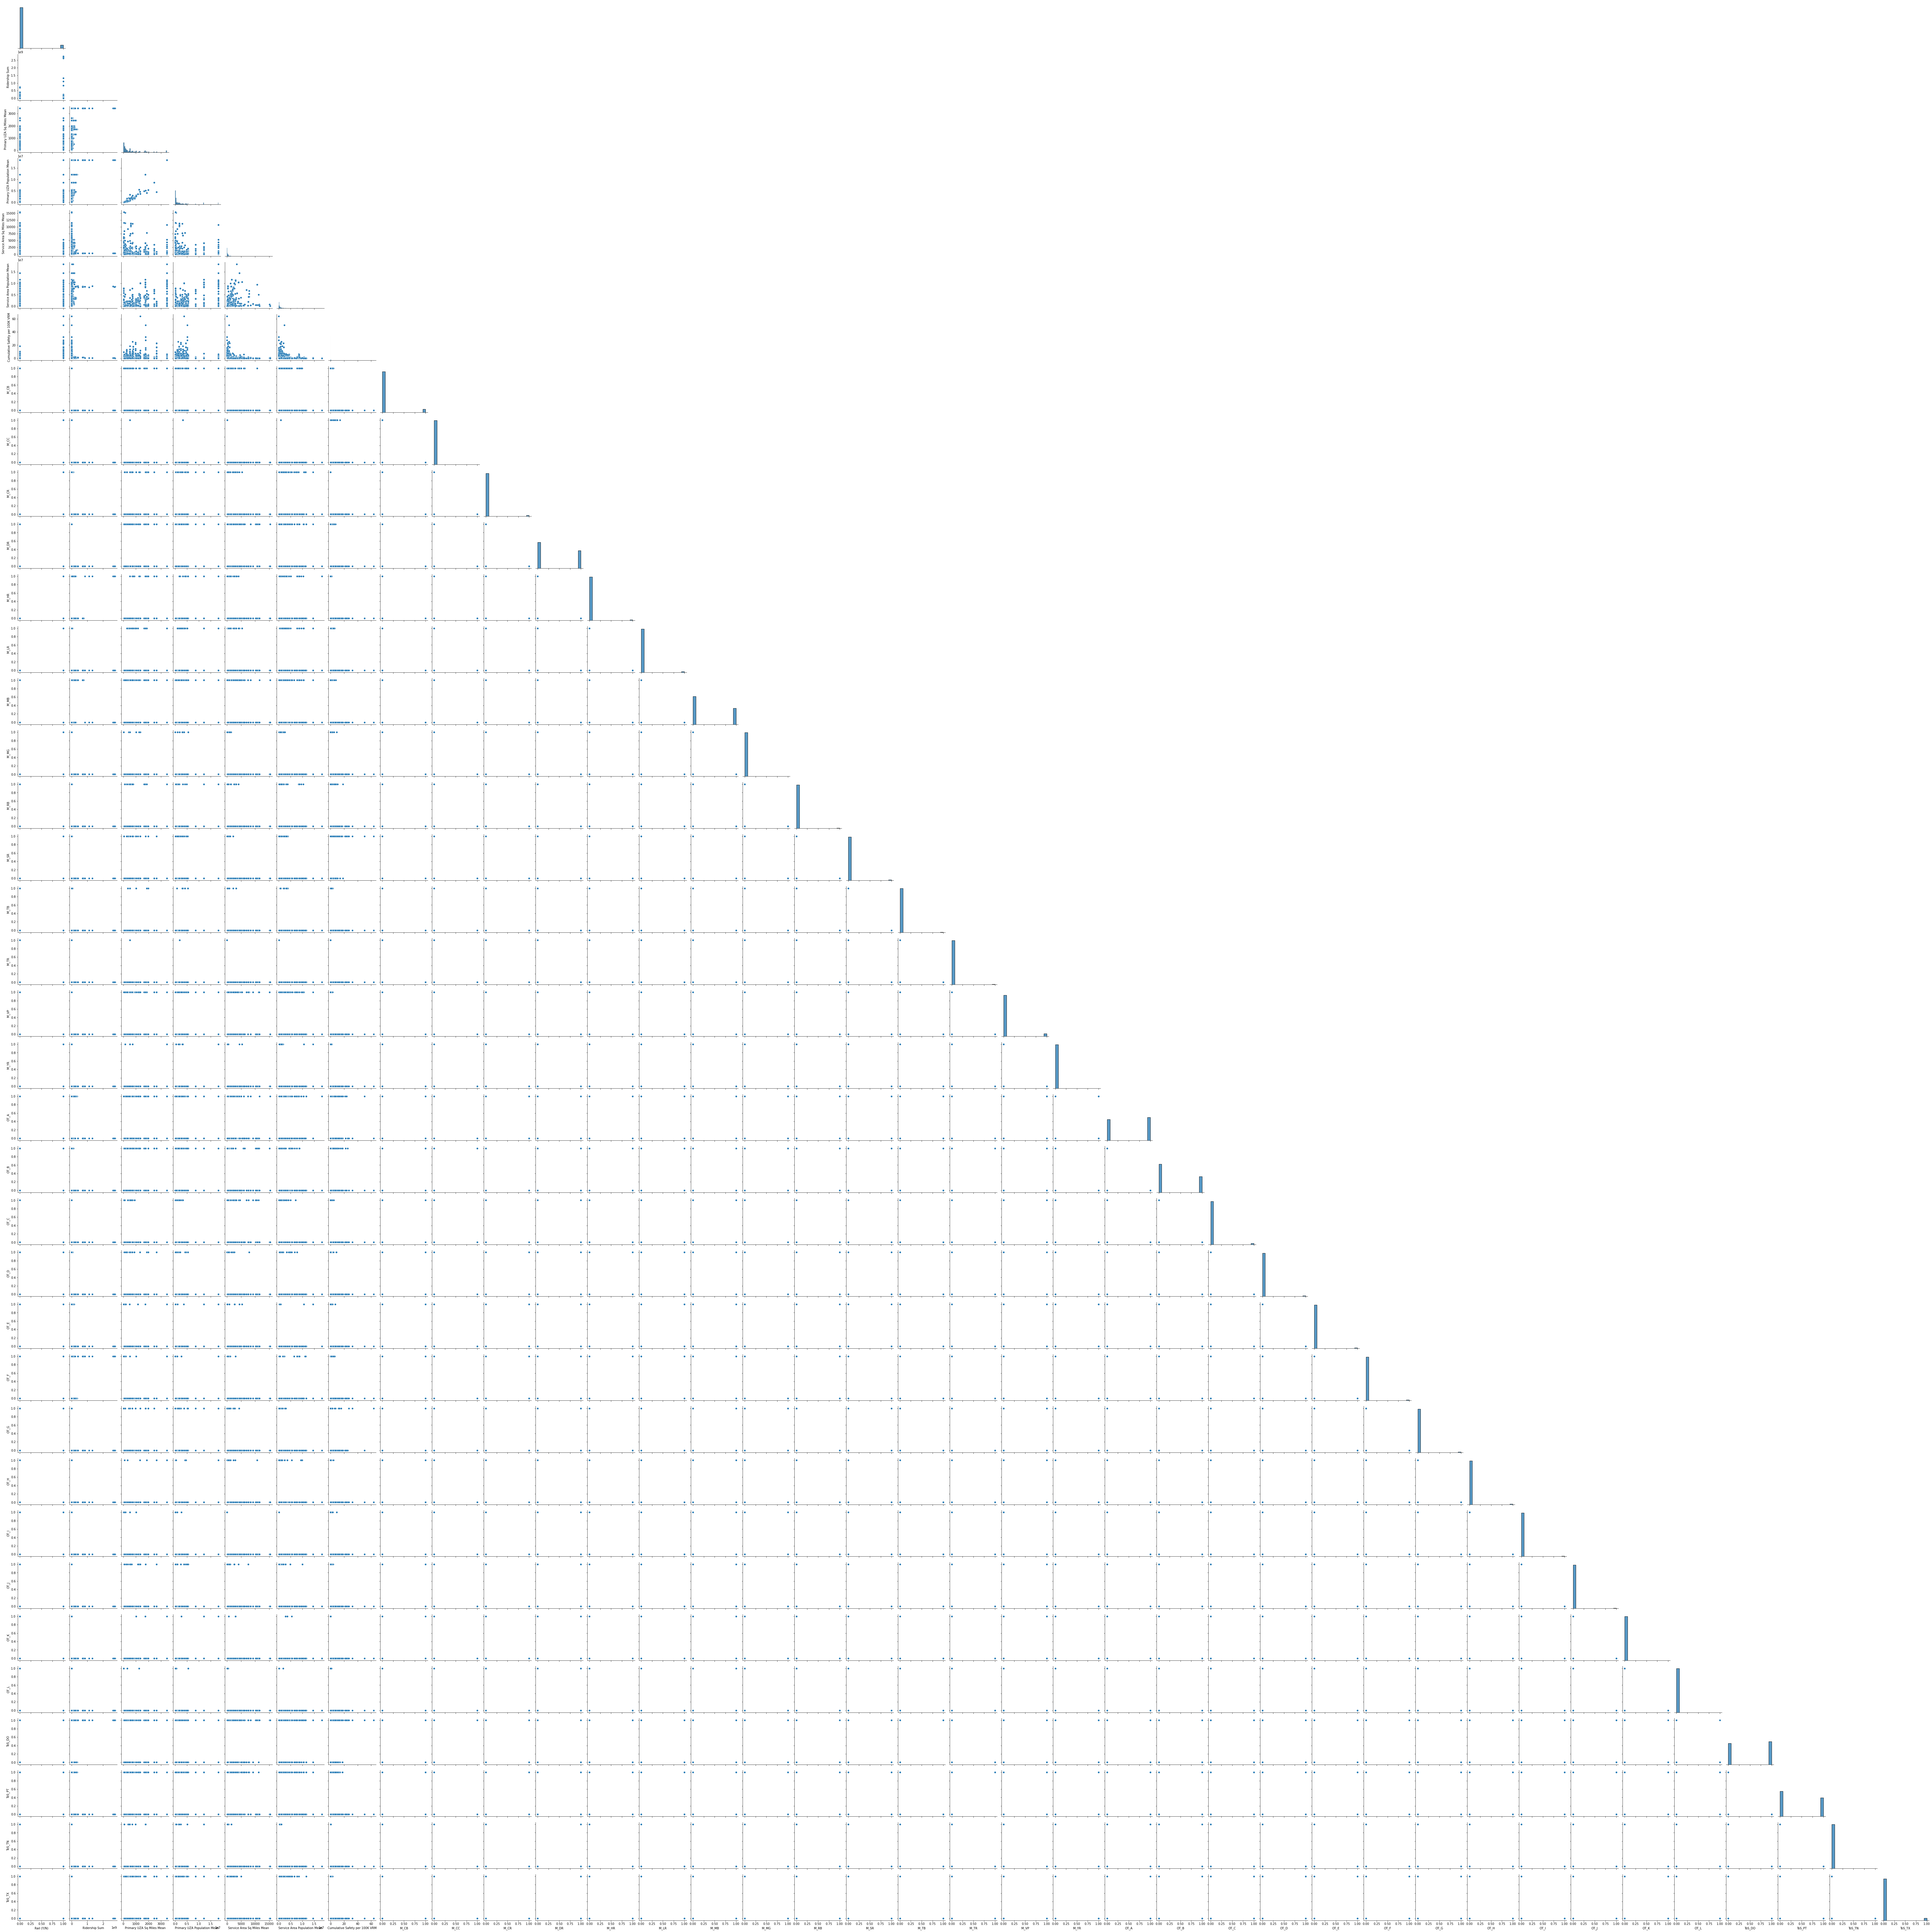

In [47]:
sns.pairplot(National_annual, corner=True)

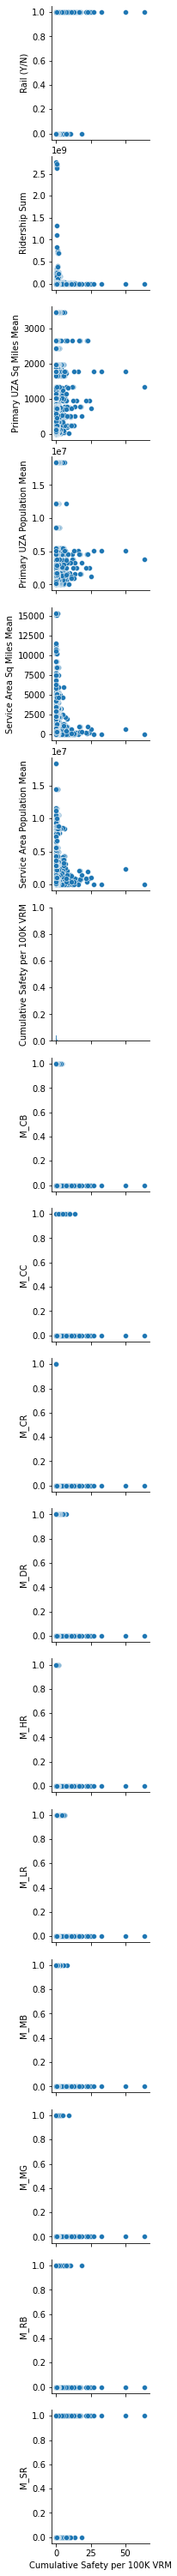

In [48]:
sns.pairplot(
    National_annual,
    x_vars=['Cumulative Safety per 100K VRM'],
    y_vars=National_annual.iloc[:, np.r_[0:17]],
)

<AxesSubplot:>

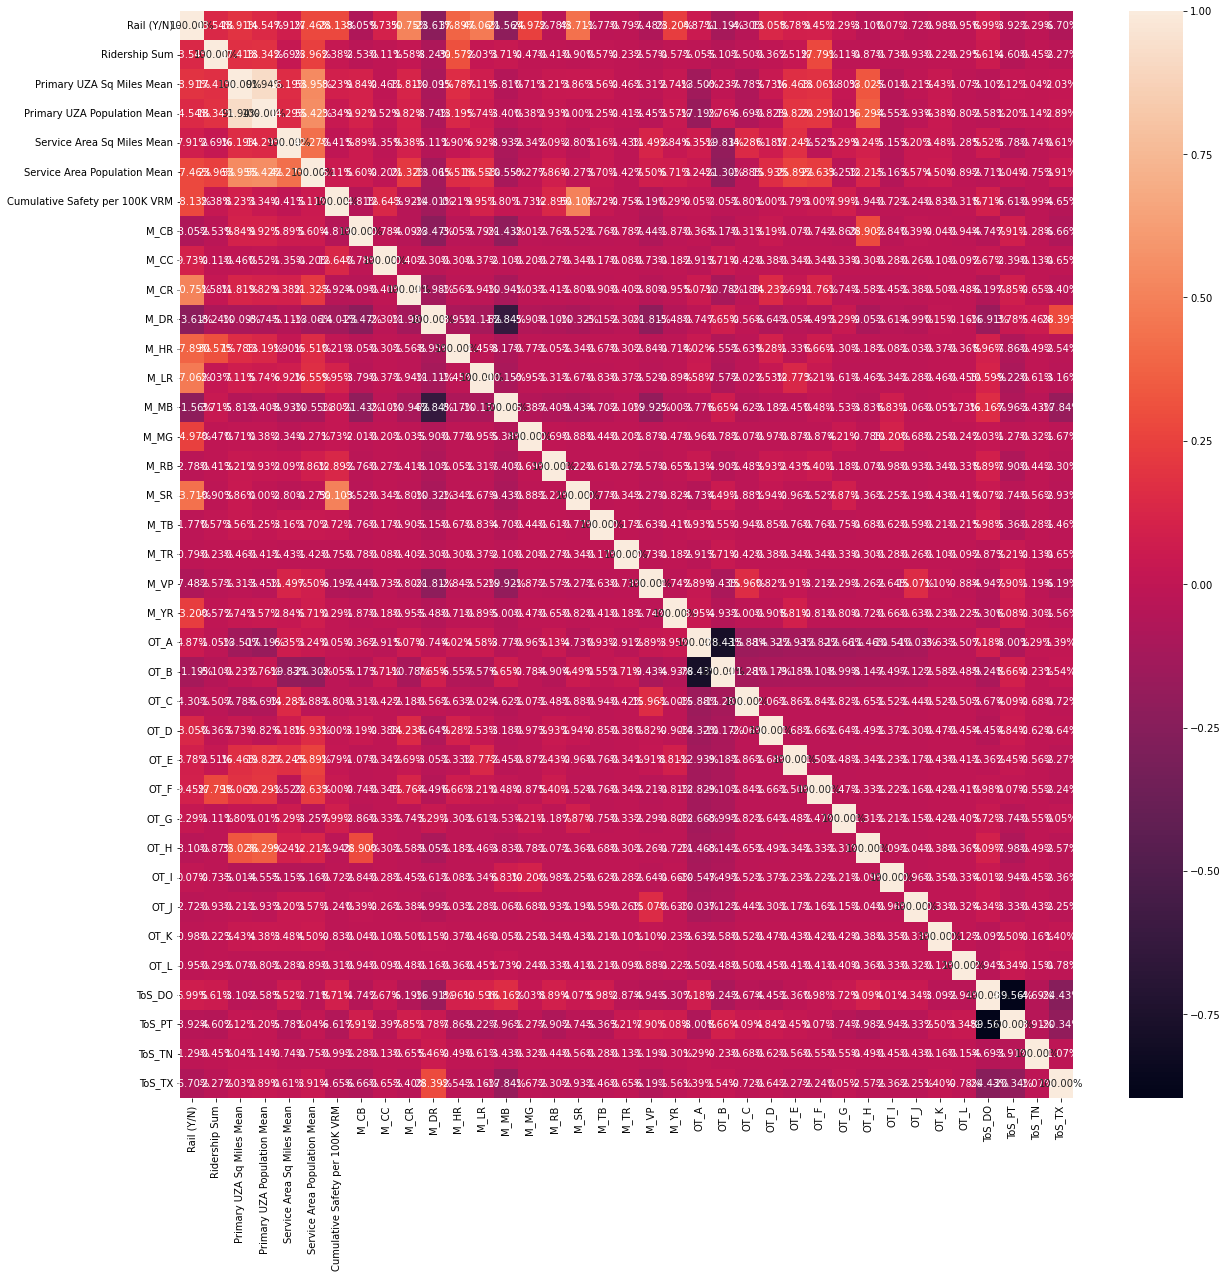

In [49]:
plt.subplots(figsize=(20,20))
sns.heatmap(National_annual.corr(), annot=True, fmt='.2%')

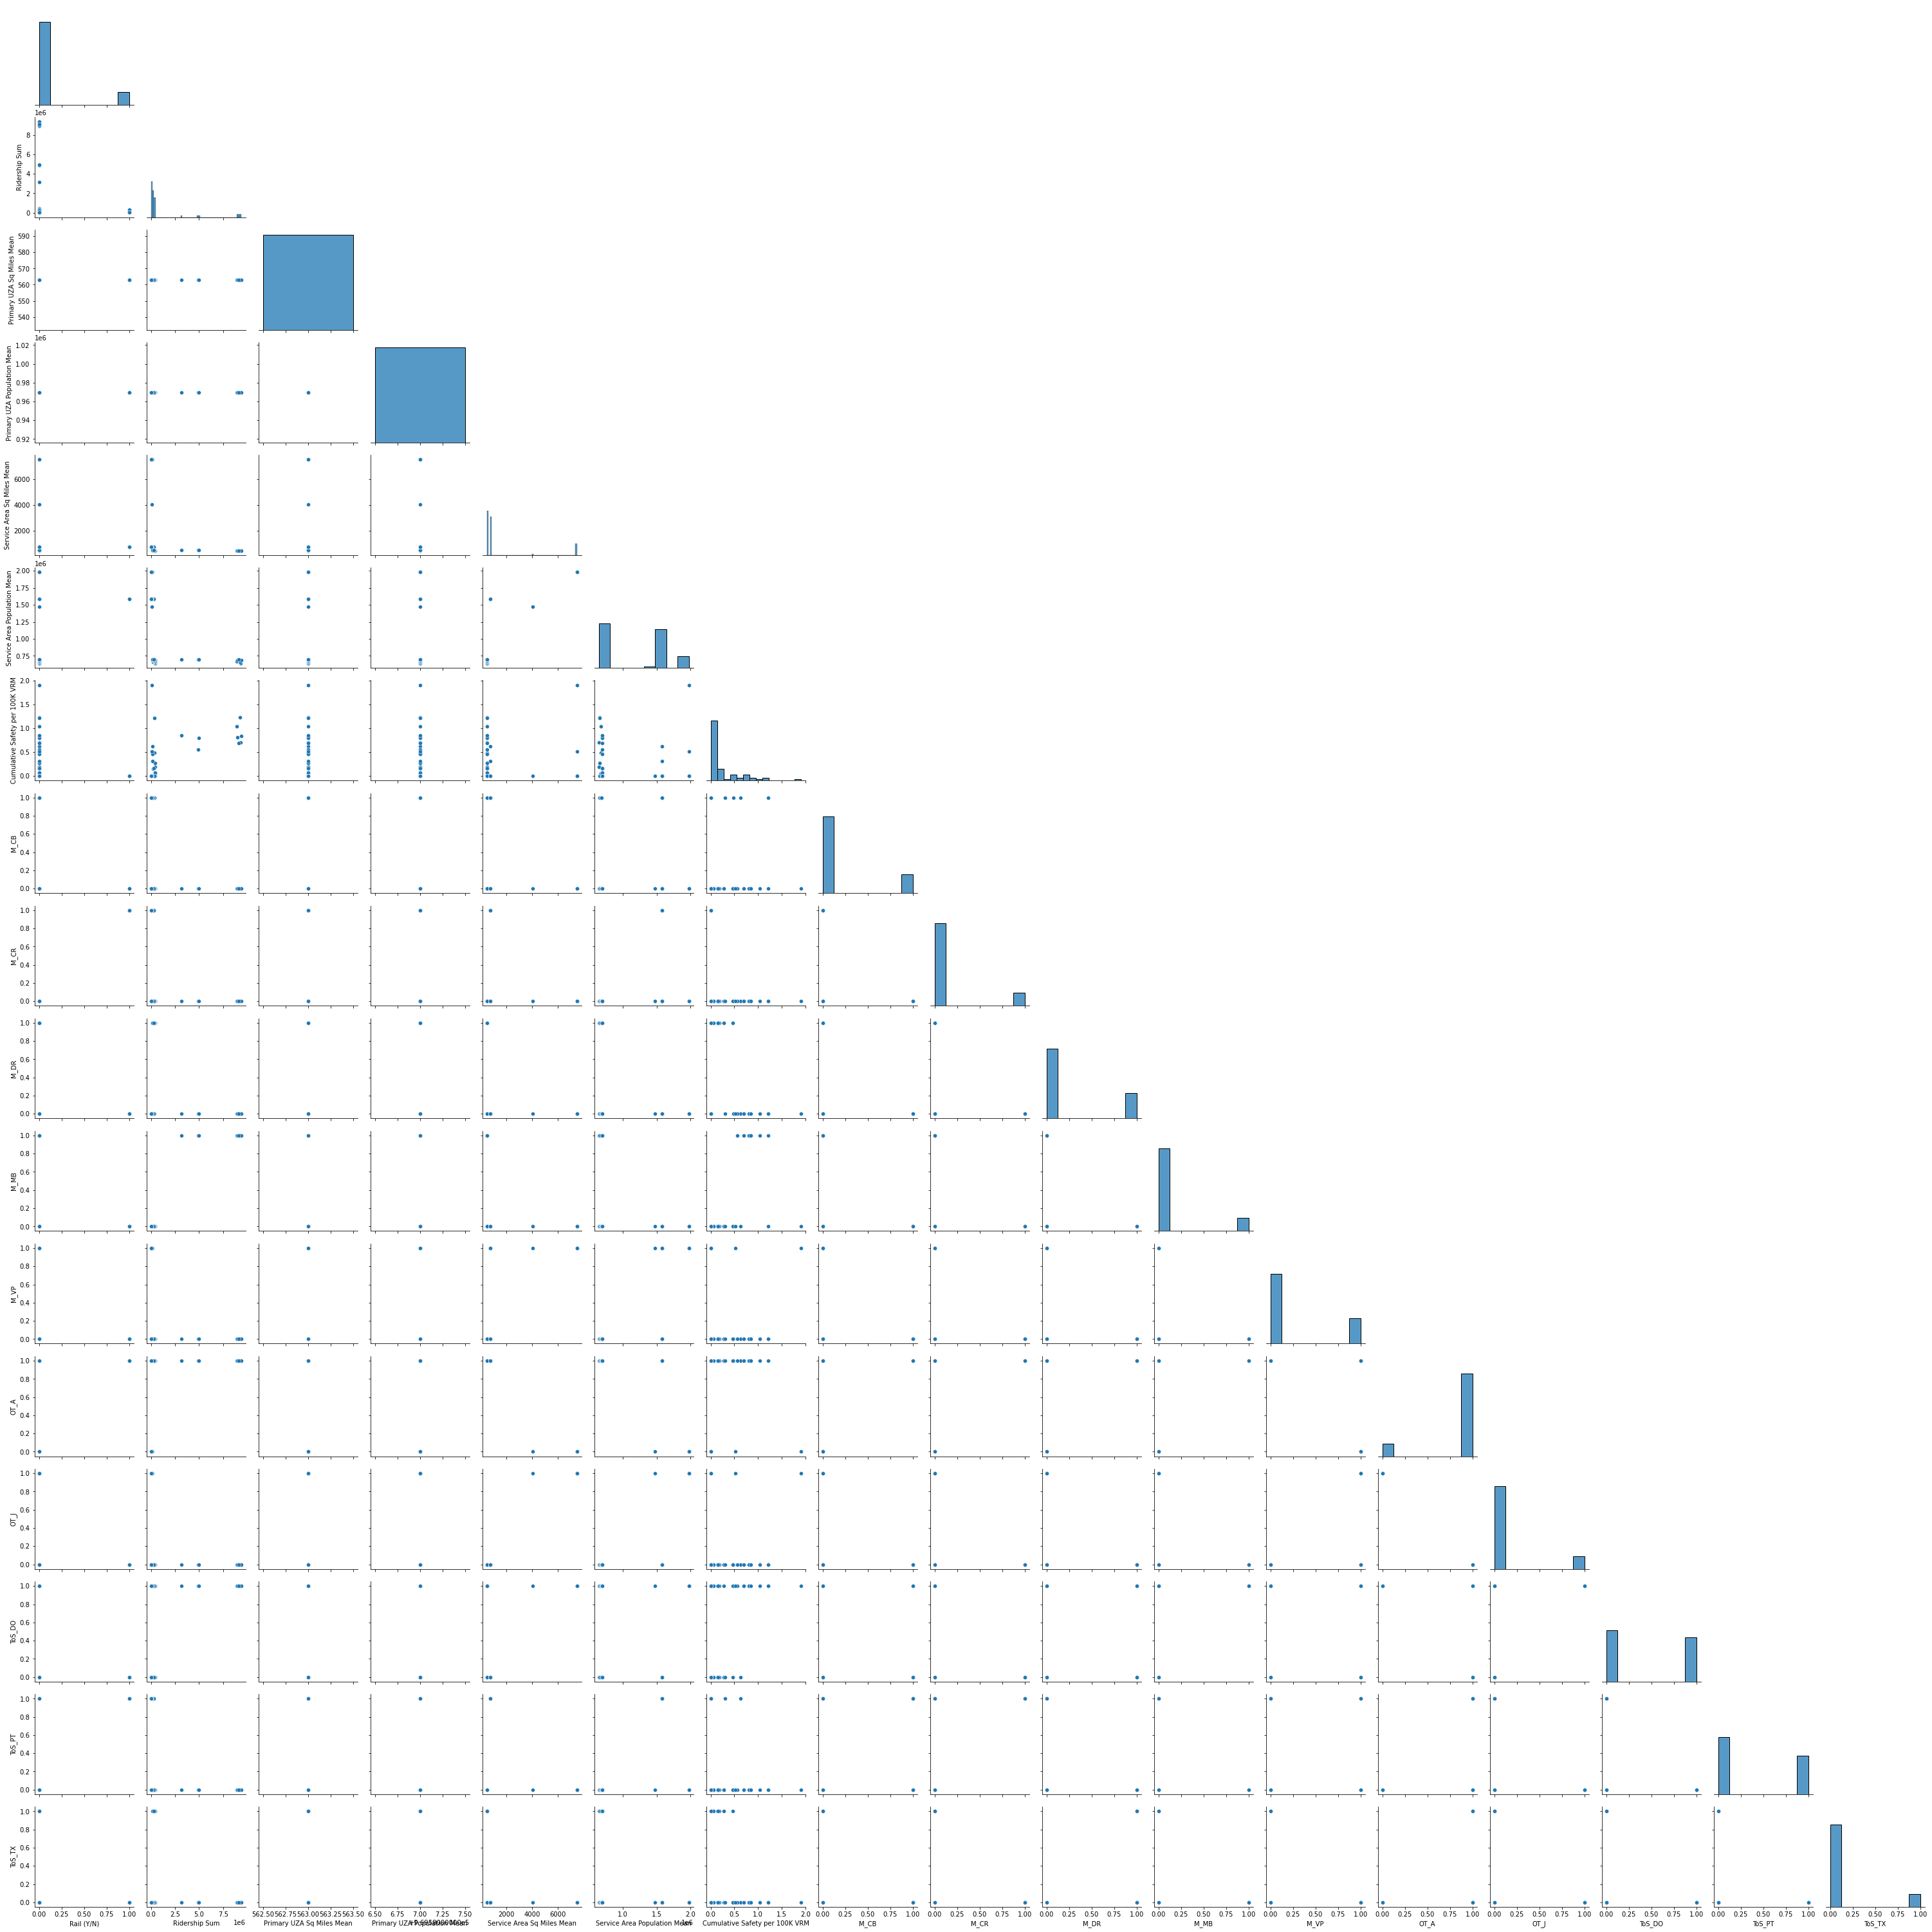

In [50]:
sns.pairplot(Nashville_annual, corner=True)

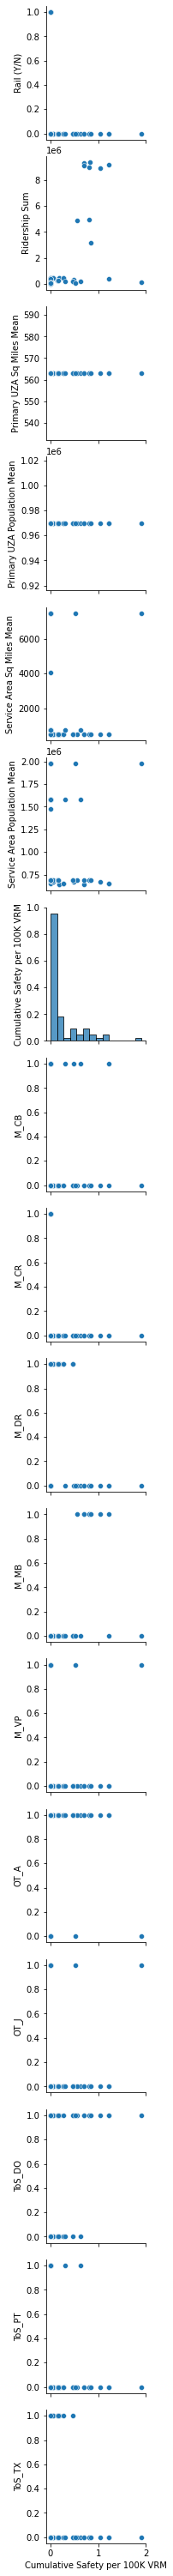

In [51]:
sns.pairplot(
    Nashville_annual,
    x_vars=['Cumulative Safety per 100K VRM'],
    y_vars=Nashville_annual.iloc[:, np.r_[0:17]],
)

<AxesSubplot:>

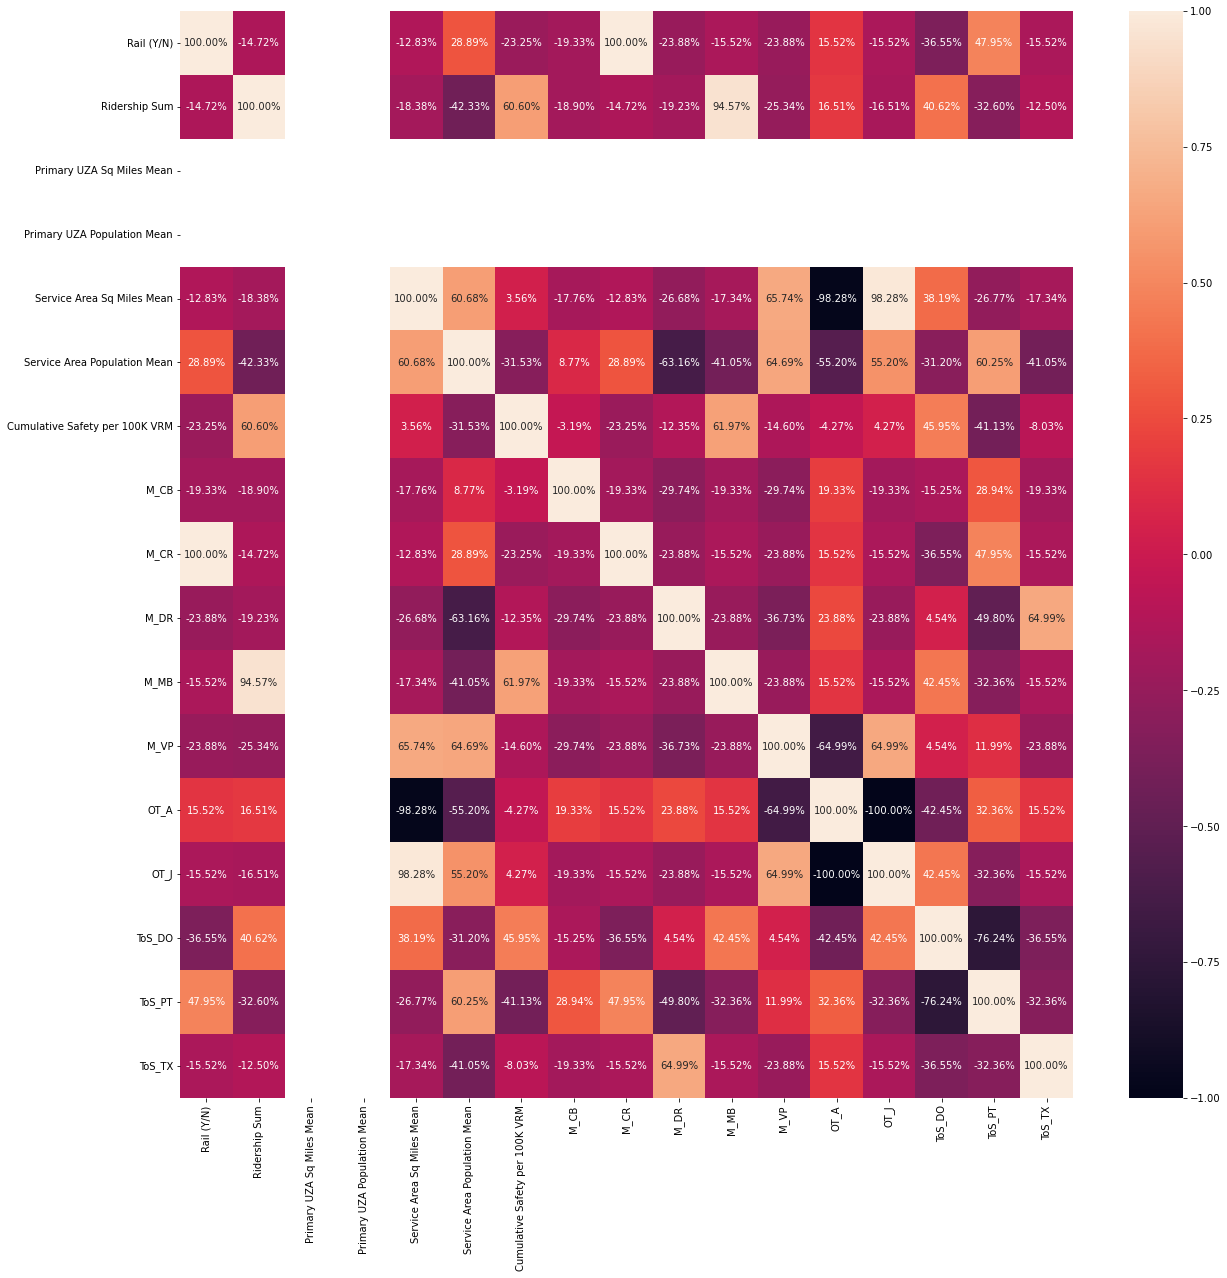

In [52]:
plt.subplots(figsize=(20,20))
sns.heatmap(Nashville_annual.corr(), annot=True, fmt='.2%')

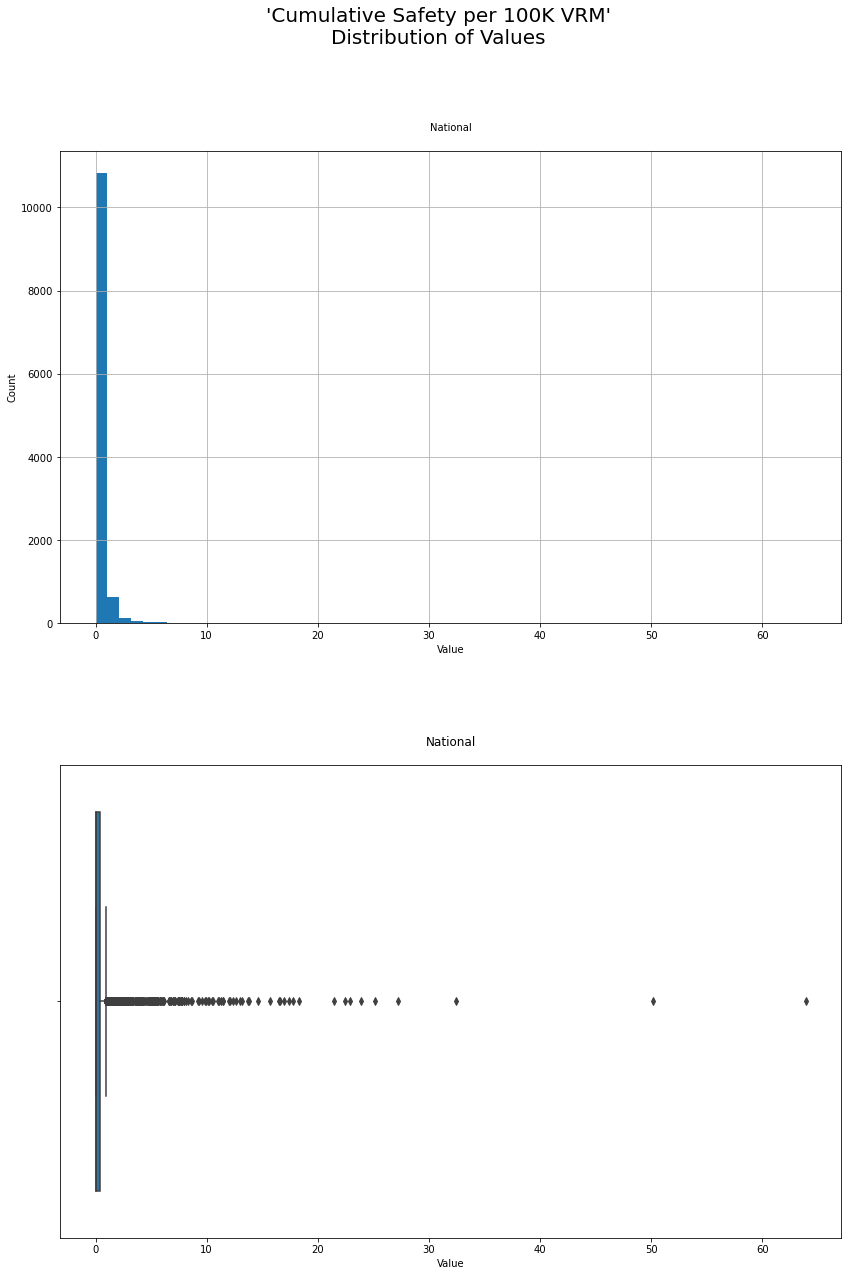

In [53]:
fig, ax =plt.subplots(2,1,figsize=(14,20), sharex=False)
fig.suptitle("'Cumulative Safety per 100K VRM'\nDistribution of Values", fontsize=20)


National_annual.hist('Cumulative Safety per 100K VRM', bins=60, ax=ax[0])
ax[0].set_title("National", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=National_annual, x='Cumulative Safety per 100K VRM', ax=ax[1])
ax[1].set_title('National', fontsize=12, pad=20)
ax[1].set_xlabel("Value");

#Nashville_annual.hist('Cumulative Safety per 100K VRM', bins=20, ax=ax[1])
#ax[1].set_title("Nashville", fontsize=10, pad=20)
#ax[1].set_xlabel("Value")
#ax[1].set_ylabel("Count")

#sns.boxplot(data=Nashville_annual, x='Cumulative Safety per 100K VRM', ax=ax[1,1])
#ax[1,1].set_title('Nashville', fontsize=12, pad=20)
#ax[1,1].set_xlabel("Value");

In [54]:
National_annual['Cumulative Safety per 100K VRM'].describe()

count    11739.000000
mean         0.366701
std          1.351690
min          0.000000
25%          0.000000
50%          0.000000
75%          0.367429
max         63.900165
Name: Cumulative Safety per 100K VRM, dtype: float64

In [55]:
National_annual['Cumulative Safety per 100K VRM'].value_counts(normalize=True)

0.000000    0.541443
0.379749    0.000511
0.189254    0.000426
0.407947    0.000256
0.414073    0.000256
              ...   
0.509963    0.000085
0.167452    0.000085
2.416206    0.000085
0.385831    0.000085
0.159695    0.000085
Name: Cumulative Safety per 100K VRM, Length: 4532, dtype: float64

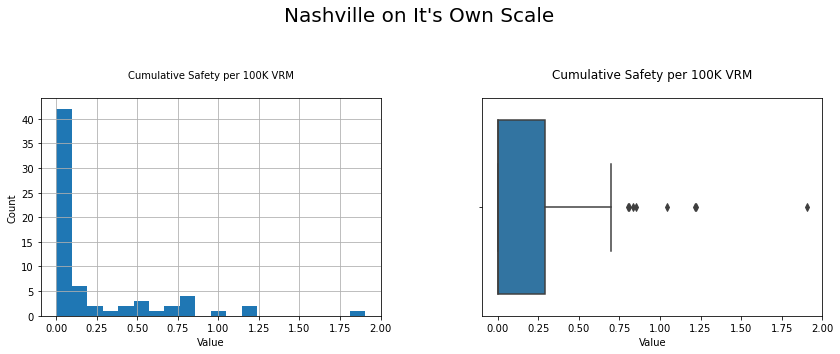

In [56]:
fig, ax =plt.subplots(1,2,figsize=(14,4))
fig.suptitle("Nashville on It's Own Scale", fontsize=20, y=1.2)

Nashville_annual.hist('Cumulative Safety per 100K VRM', bins=20, ax=ax[0])
ax[0].set_title("Cumulative Safety per 100K VRM", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=Nashville_annual, x='Cumulative Safety per 100K VRM', ax=ax[1])
ax[1].set_title('Cumulative Safety per 100K VRM', fontsize=12, pad=20)
ax[1].set_xlabel("Value");


In [57]:
Nashville_annual['Cumulative Safety per 100K VRM'].describe()

count    67.000000
mean      0.227242
std       0.387990
min       0.000000
25%       0.000000
50%       0.000000
75%       0.288672
max       1.905168
Name: Cumulative Safety per 100K VRM, dtype: float64

In [58]:
Nashville_annual['Cumulative Safety per 100K VRM'].value_counts(normalize=True)

0.000000    0.567164
0.184577    0.029851
0.272062    0.029851
0.463321    0.029851
0.155612    0.029851
0.057207    0.029851
0.144311    0.029851
0.062033    0.029851
0.305282    0.014925
0.849268    0.014925
0.800613    0.014925
0.556250    0.014925
0.693343    0.014925
0.830848    0.014925
1.905168    0.014925
0.694989    0.014925
0.808993    0.014925
0.625532    0.014925
0.483563    0.014925
1.042051    0.014925
1.214444    0.014925
1.220823    0.014925
0.515821    0.014925
Name: Cumulative Safety per 100K VRM, dtype: float64

## 3.8 Model Selection
<a id= '3.8_Model_Selection'></a>

### 3.8.1 Train/Test Split
<a id= '3.8.1_Train_Test_Split'></a>

In [59]:
#Defining X and y from National_data

X_National = National_annual.drop(['Cumulative Safety per 100K VRM'], axis = 1)
y_National = National_annual['Cumulative Safety per 100K VRM']

In [60]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X_National, y_National, test_size=0.2, random_state=42)
#X_train.info()

### 3.8.2 Linear Regression
<a id= '3.8.2_Linear_Regression'></a>
I would not expect linear regression to work well because of the number of discrete variables in the dataset, but I will try it anyway.

In [61]:
Model_lr = LinearRegression()

In [62]:
Model_lr.fit(X_train, y_train)

LinearRegression()

In [63]:
y_pred_lr = Model_lr.predict(X_test)

In [64]:
#Evaluation

R2_score_lr = Model_lr.score(X_train, y_train)
print("R Squared score:", R2_score_lr)

MAPE_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print("MAPE:", MAPE_lr)

MAE_lr = mean_absolute_error(y_test, y_pred_lr)
#MAE_lr_values = mean_absolute_error(y_test, y_pred_lr, multioutput='raw_values')
print("MAE:", MAE_lr)

MSE_lr = mean_squared_error(y_test, y_pred_lr)
print("MSE:", MSE_lr)

R Squared score: 0.330238474467508
MAPE: 628118757137389.2
MAE: 0.34196128503547224
MSE: 0.542575403920239


In [65]:
diff_lr = (y_test - y_pred_lr)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_lr_series = pd.Series(y_pred_lr, name='y_pred_lr')
diff_lr_series = pd.Series(diff_lr, name='residual_lr')

y_pred_lr_series.index = y_test_series.index

data_lr=pd.concat([y_test_series, y_pred_lr_series, diff_lr_series], axis=1)



data_lr



,y_test,y_pred_lr,residual_lr
127221,0.000000,0.196288,-0.196288
11741,0.000000,-0.050384,0.050384
20747,0.000000,0.026309,-0.026309
36283,0.899705,0.685195,0.214510
29623,0.000000,0.068202,-0.068202
...,...,...,...
128522,0.525800,0.429285,0.096516
14805,0.369764,0.383767,-0.014003
8349,0.000000,0.083884,-0.083884
44773,0.385831,0.282040,0.103791


In [66]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_lr = data_lr.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_lr": ["min", "max", "median", "mean", mode, "std"],
        "residual_lr": ["min", "max", "median", "mean", mode, "std"],})
data_agg_lr

,y_test,y_pred_lr,residual_lr
min,0.000000,-0.245964,-7.153069
max,12.596256,7.153069,8.220264
median,0.000000,0.228315,-0.064561
mean,0.328628,0.363738,-0.035110
<lambda>,0.000000,0.959039,-0.959039
std,0.807607,0.757033,0.735917


### 3.8.3 Random Forest
<a id= '3.8.3_Random_Forest'></a>

In [67]:
Model_rf = RandomForestRegressor()

In [68]:
Model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [69]:
y_pred_rf = Model_rf.predict(X_test)

In [70]:
#Evaluation

R2_score_rf = Model_rf.score(X_train, y_train)
print("R Squared score:", R2_score_rf)

MAPE_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
print("MAPE:", MAPE_rf)

MAE_rf = mean_absolute_error(y_test, y_pred_rf)
#MAE_rf_values = mean_absolute_error(y_test, y_pred_rf, multioutput='raw_values')
print("MAE:", MAE_rf)

MSE_rf = mean_squared_error(y_test, y_pred_rf)
print("MSE:", MSE_rf)

R Squared score: 0.9024831832794713
MAPE: 414520384690047.25
MAE: 0.24506460388830353
MSE: 0.5238875207163035


In [71]:
diff_rf = (y_test - y_pred_rf)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_rf_series = pd.Series(y_pred_rf, name='y_pred_rf')
diff_rf_series = pd.Series(diff_rf, name='residual_rf')

y_pred_rf_series.index = y_test_series.index

data_rf=pd.concat([y_test_series, y_pred_rf_series, diff_rf_series], axis=1)
data_rf




,y_test,y_pred_rf,residual_rf
127221,0.000000,0.010360,-0.010360
11741,0.000000,0.017289,-0.017289
20747,0.000000,0.007561,-0.007561
36283,0.899705,0.142871,0.756834
29623,0.000000,0.653196,-0.653196
...,...,...,...
128522,0.525800,0.205386,0.320414
14805,0.369764,0.131649,0.238115
8349,0.000000,0.258966,-0.258966
44773,0.385831,0.081539,0.304291


In [72]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_rf = data_rf.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_rf": ["min", "max", "median", "mean", mode, "std"],
        "residual_rf": ["min", "max", "median", "mean", mode, "std"],})
data_agg_rf

,y_test,y_pred_rf,residual_rf
min,0.000000,0.000000,-12.714113
max,12.596256,15.893482,7.084463
median,0.000000,0.145709,-0.029988
mean,0.328628,0.372550,-0.043922
<lambda>,0.000000,0.000000,0.000000
std,0.807607,0.959169,0.722621


### 3.8.4 KNN
<a id= '3.8.4_KNN'></a>

In [73]:
Model_knn = KNeighborsRegressor()

In [74]:
Model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [75]:
y_pred_knn = Model_knn.predict(X_test)

In [76]:
#Evaluation

R2_score_knn = Model_knn.score(X_train, y_train)
print("R Squared score:", R2_score_knn)

MAPE_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
print("MAPE:", MAPE_knn)

MAE_knn = mean_absolute_error(y_test, y_pred_knn)
#MAE_knn_values = mean_absolute_error(y_test, y_pred_knn, multioutput='raw_values')
print("MAE:", MAE_knn)

MSE_knn = mean_squared_error(y_test, y_pred_knn)
print("MSE:", MSE_knn)

R Squared score: 0.3848088023849705
MAPE: 536627057422043.8
MAE: 0.3298535793727484
MSE: 0.9181240880845323


In [77]:
diff_knn = (y_test - y_pred_knn)

y_test_series = pd.Series(y_test, name='y_test')
y_pred_knn_series = pd.Series(y_pred_knn, name='y_pred_knn')
diff_knn_series = pd.Series(diff_knn, name='residual_knn')

y_pred_knn_series.index = y_test_series.index

data_knn=pd.concat([y_test_series, y_pred_knn_series, diff_knn_series], axis=1)
data_knn




,y_test,y_pred_knn,residual_knn
127221,0.000000,0.247712,-0.247712
11741,0.000000,0.000000,0.000000
20747,0.000000,0.000000,0.000000
36283,0.899705,0.339919,0.559786
29623,0.000000,0.285494,-0.285494
...,...,...,...
128522,0.525800,0.155114,0.370686
14805,0.369764,0.043329,0.326435
8349,0.000000,0.222049,-0.222049
44773,0.385831,0.129307,0.256523


In [78]:
mode = lambda x: pd.Series.mode(x)[0]
data_agg_knn = data_knn.agg({
        "y_test": ["min", "max", "median", "mean", mode, "std"],
        "y_pred_knn": ["min", "max", "median", "mean", mode, "std"],
        "residual_knn": ["min", "max", "median", "mean", mode, "std"],})
data_agg_knn

,y_test,y_pred_knn,residual_knn
min,0.000000,0.000000,-18.276969
max,12.596256,18.276969,11.850477
median,0.000000,0.159989,-0.004181
mean,0.328628,0.351030,-0.022402
<lambda>,0.000000,0.000000,0.000000
std,0.807607,0.864302,0.958130


### 3.8.5 Comparing the Models' Performance
<a id='3.8.5_Comparing_the_Models_Performance'></a>


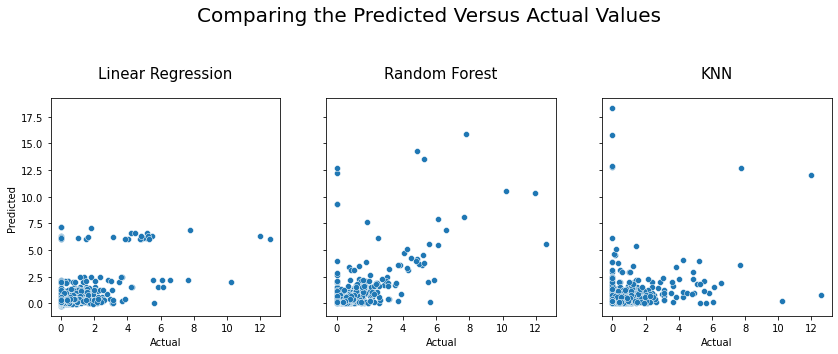

In [79]:
#Comparing the Predicted Versus Actual Values

fig, ax =plt.subplots(1,3,figsize=(14,4), sharey=True, sharex=True)
fig.suptitle("Comparing the Predicted Versus Actual Values", fontsize=20, y=1.2)


sns.scatterplot(x=y_test, y=y_pred_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")

sns.scatterplot(x=y_test, y=y_pred_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Predicted")

sns.scatterplot(x=y_test, y=y_pred_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Actual")
ax[2].set_ylabel("Predicted");



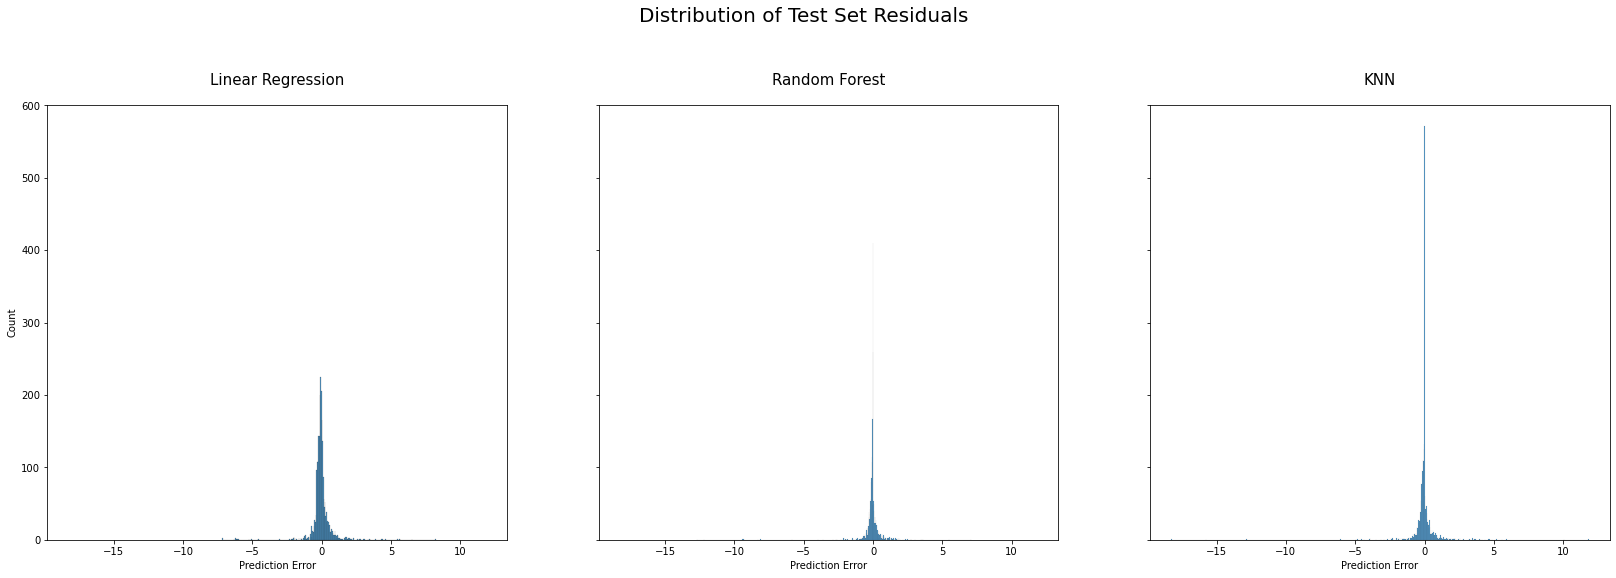

In [80]:
#Comparing the Residuals

fig, ax =plt.subplots(1,3,figsize=(28,8), sharey=True, sharex=True)
fig.suptitle("Distribution of Test Set Residuals", fontsize=20, y=1.05)


sns.histplot(diff_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Prediction Error")
ax[0].set_ylabel("Count")

sns.histplot(diff_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Prediction Error")
ax[1].set_ylabel("Count")

sns.histplot(diff_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Prediction Error")
ax[2].set_ylabel("Count");


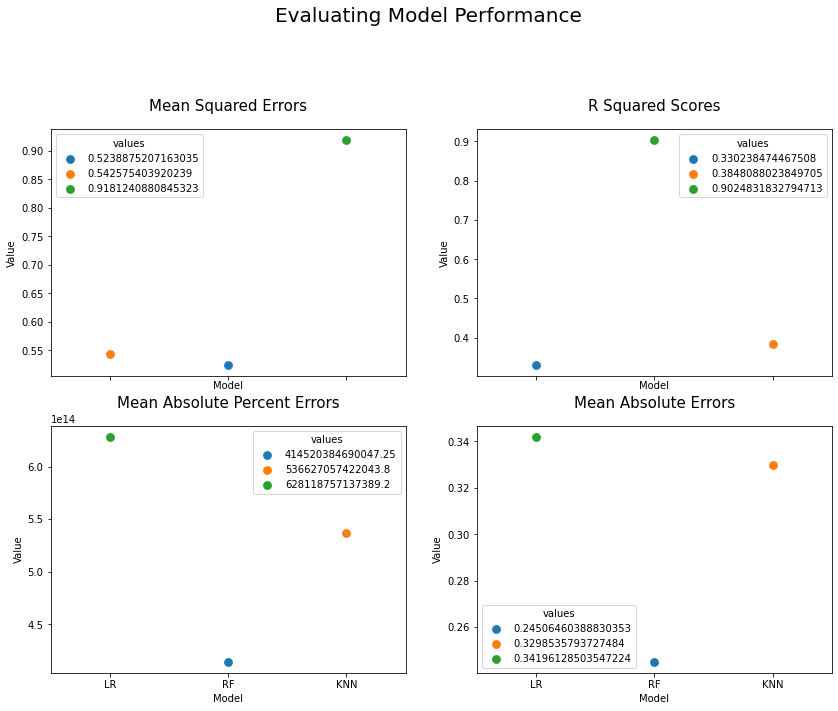

In [81]:
#Comparing the Mean Squared Error

MSEs = pd.Series([MSE_lr, MSE_rf, MSE_knn], name='values')
R2s = pd.Series([R2_score_lr, R2_score_rf, R2_score_knn], name='values')
MAPEs = pd.Series([MAPE_lr, MAPE_rf, MAPE_knn], name='values')
MAEs = pd.Series([MAE_lr, MAE_rf, MAE_knn], name='values')
labels = pd.Series(['LR','RF','KNN'], name='labels')

fig, ax =plt.subplots(2,2,figsize=(14,10), sharex=True)
fig.suptitle("Evaluating Model Performance", fontsize=20, y=1.05)

sns.pointplot(data=pd.concat([MSEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[0,0], hue='values')
ax[0,0].set_title("Mean Squared Errors", fontsize=15, y=1.05)
ax[0,0].set_xlabel("Model", fontsize=10)
ax[0,0].set_ylabel("Value", fontsize=10, x=1.05)

sns.pointplot(data=pd.concat([R2s, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[0,1], hue='values')
ax[0,1].set_title("R Squared Scores", fontsize=15, y=1.05)
ax[0,1].set_xlabel("Model", fontsize=10)
ax[0,1].set_ylabel("Value", fontsize=10, x=1.05);

sns.pointplot(data=pd.concat([MAPEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[1,0], hue='values')
ax[1,0].set_title("Mean Absolute Percent Errors", fontsize=15, y=1.05)
ax[1,0].set_xlabel("Model", fontsize=10)
ax[1,0].set_ylabel("Value", fontsize=10, x=1.05)

sns.pointplot(data=pd.concat([MAEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[1,1], hue='values')
ax[1,1].set_title("Mean Absolute Errors", fontsize=15, y=1.05)
ax[1,1].set_xlabel("Model", fontsize=10)
ax[1,1].set_ylabel("Value", fontsize=10, x=1.05);

Comment on above here

## 3.9 Save the Data
<a id='3.9_Save_the_Data'></a>

In [82]:
National_data.to_csv("National_data_post_preprocessing.csv", index=False)
Nashville_data.to_csv("Nashville_data_post_preprocessing.csv", index=False)
National_annual.to_csv("National_annual.csv", index=False)
Nashville_annual.to_csv("Nashville_annual.csv", index=False)

## 3.10 Summary
<a id='3.10_Summary'></a>

This notebook ends with fully refined dataframes for both the National and Nashville data.  The dependent variable, 'Cumulative Safety per 100K VRM', was clearly defined.  The independent variables were first reduced to avoid overcorrelation and the columns identifying time and location were removed.  After that, the categorical variables were one hot encoded.

**REDO THIS SECTION** Three models were evaluated.  Linear Regression was found not to be useful at all, which was predictable because of the number of discrete variables.  Random Forest and KNN both performed exceedingly well.  